In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
from lib.DrugUtil import flatten, DrugUtil

import plotly.express as px
from lib.FhirDataUtil import FhirDataUtil
from lib.CCSDataUtil import CCSDataUtil

def printmd(string):
    display(string)

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_colwidth', None)

_fhir_conditions_file = "input/fhir_20230423/fhir_conditions.csv"
_fhir_medications_file = "input/fhir_20230423/fhir_medications.csv"
_fhir_medications_ref_file = "input/fhir_20230423/fhir_medication_references2.csv"
_fhir_demographics_file = "input/fhir_20230423/fhir_demographics.csv"
_output_dir = 'output/'

_rxnorm_file = "input_static/RxTerms202203/RxTerms202203.txt"
_rxnorm_ingredients_file = "input_static/RxTerms202203/RxTermsIngredients202203.txt"
_rxclass_file = "input_static/_rxclass_2022-04-10.csv"

_ccs_demographics_file = "input/ccs_demographics.csv"
_ccs_medications_file = "input/ccs_medications.csv"
_ccs_conditions_file = "input/ccs_conditions.csv"
_ccs_medications_preprocessed_file = "input/ccs_medications_preprocessed.csv"

_pc_demographics_file = "input/pcornet/demographic_fhir.csv"
_pc_medications_file = "input/pcornet/med_pres_fhir_v2.csv"
_pc_medications_query_file = "input/pc_medications_query.xlsx"

# Chart Review
_cr_file = 'input/chart_review/Chart_Review1.2b.xlsx'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
fhirUtil = FhirDataUtil()
drugUtil = DrugUtil()
ccsUtil = CCSDataUtil(drugUtil)


drugUtil.load(rxnorm_file=_rxnorm_file,
                        rxnorm_ingredients_file=_rxnorm_ingredients_file, 
                        rxclass_file=_rxclass_file)

fhirUtil.load_conditions(fhir_conditions_file=_fhir_conditions_file, remove_health_concerns=True)
fhirUtil.load_medications(medications_fhir_file=_fhir_medications_file, medications_ref_fhir_file=_fhir_medications_ref_file)
fhirUtil.load_demographics(fhir_demographics_file=_fhir_demographics_file)


ccsUtil.load_conditions(ccs_conditions_file= _ccs_conditions_file)
ccsUtil.load_medications(ccs_medications_file=_ccs_medications_file)
# ccsUtil.medications = ccsUtil.medications.drop_duplicates(subset=['user_id', 'rxcui'])
# ccsUtil.add_ingredient_column()
ccsUtil.load_demographics(_ccs_demographics_file)

fhir_meds = fhirUtil.medications

# Reading rxclass file...
# Reading rxnorm file...
# RAW FHIR conditions: 52621
# FHIR conditions after pre-processing: 37248
# ----- Loading Medications ------
# Raw FHIR records: 15061
# After de-duplicated: 7403
# Merge with reference counts:
# left_only     5133
# both          2236
# right_only       0
# Name: _merge, dtype: int64
# Loaded FHIR medication records 31976  Includes multiple code mappings
# Unique users with fhir medications:  1122
# ------  Done Loading Medications -----
# Loaded CCS conditions records: 94735

Reading rxclass file...
Reading rxnorm file...
RAW FHIR conditions: 74880
FHIR conditions after pre-processing: 52030
----- Loading Medications ------
Raw FHIR records: 21695
After de-duplicated: 10395
Merge with reference counts:
left_only     6300
both          4019
right_only       0
Name: ref_merge, dtype: int64
Loaded FHIR medication records 55313  Includes multiple code mappings
Unique users with fhir medications:  1458
------  Done Loading Medications -----


/app/lib/CCSDataUtil.py:13: DtypeWarning: Columns (5,6,11,12,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.conditions = pd.read_csv(ccs_conditions_file, delimiter=',')


Loaded CCS conditions records: 94735


/app/lib/CCSDataUtil.py:20: DtypeWarning: Columns (16,20) have mixed types. Specify dtype option on import or set low_memory=False.
  self.medications_raw = pd.read_csv(ccs_medications_file)


Loaded demographics file with entries:  98877


/app/lib/CCSDataUtil.py:75: DtypeWarning: Columns (11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  self.demographics = pd.read_csv(ccs_demographics)


In [11]:
# Load chart review data
from pathlib import Path
xls = pd.ExcelFile(_cr_file, engine='openpyxl')
# file = Path(_cr_file)
# pd.read_excel(_cr_file, engine='openpyxl', sheet_name='Medications')

cr_meds_raw = pd.read_excel(xls, 'Medications')
cr_demo = pd.read_excel(xls, 'users_to_query')
cr_meds_raw['start_date_d'] = pd.to_datetime(cr_meds_raw['start_date'], errors='coerce')
cr_meds = cr_meds_raw.copy()

In [12]:
# Load PC demo

pc_meds_raw = pd.read_csv(_pc_medications_file)
pc_demo = pd.read_csv(_pc_demographics_file)

def generate_ingredients_column(row, colName='rx'):
#     print('--------', row['raw_rx_med_name'])
    s = drugUtil.findIngredientsByRxcui(row[colName], verbose=False)
    if s is not None:
        return s['ING_RXCUI'].array
    else:
        return np.nan
pc_meds = pc_meds_raw.copy()
pc_meds['rx_order_date_d'] = pd.to_datetime(pc_meds['rx_order_date'])
# pc_meds['rxcui_ing'] = pc_meds.apply(generate_ingredients_column, axis=1)
# pc_meds = pc_meds.explode('rxcui_ing')
pc_meds_query = pd.read_excel(_pc_medications_query_file)
pc_meds_query = pc_meds_query[pc_meds_query['CODETYPE'] == 'RXCUI']
print('Total Entries (includes multiple for ingredients) ', len(pc_meds))

Total Entries (includes multiple for ingredients)  7789


In [20]:
len(fhirUtil.medications)

55313

In [14]:
# Because processing raw medications takes a very long time (particularly recognizing custom meds 
# and adding ingredients), best to skip and load pre-processed file

# ccsUtil.medications = pd.read_csv(_ccs_medications_preprocessed_file)

# Show Date Ranges for all datasets

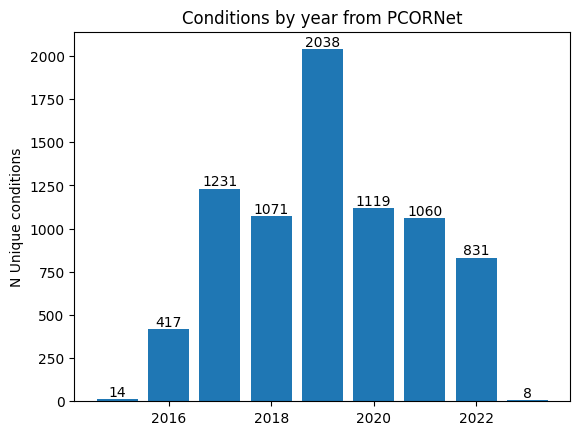

6924   2015-12-01
6964   2015-12-02
7036   2015-12-03
651    2015-12-05
548    2015-12-05
          ...    
4245   2023-02-11
4159   2023-03-11
4246   2023-03-11
4409   2023-04-21
4360   2023-04-21
Name: rx_order_date_d, Length: 7789, dtype: datetime64[ns]

In [9]:
import matplotlib.pyplot as plt
years = pc_meds['rx_order_date_d'].dt.year.value_counts().reset_index(name="Medications")
bar = plt.bar(years['index'], years['Medications'])
plt.bar_label(bar)
plt.title('Conditions by year from PCORNet')
plt.ylabel('N Unique conditions')
plt.show()
pc_meds['rx_order_date_d'].dropna().sort_values()

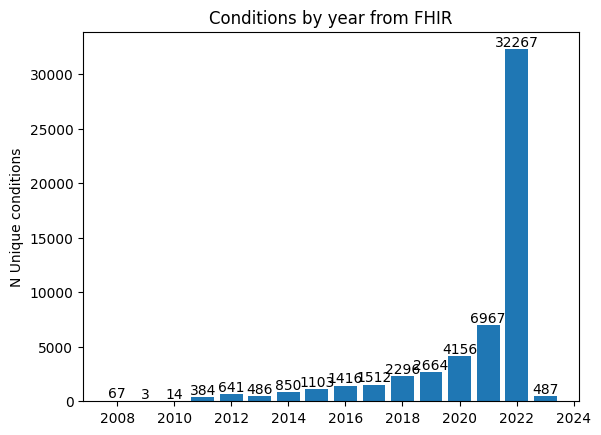

17716   2008-01-02 00:00:00+00:00
44594   2008-03-24 18:53:47+00:00
44593   2008-03-24 18:53:47+00:00
23798   2008-04-28 15:03:57+00:00
41068   2008-09-23 15:40:10+00:00
                   ...           
20058   2023-01-04 23:50:05+00:00
20059   2023-01-04 23:50:05+00:00
20060   2023-01-04 23:50:05+00:00
20053   2023-01-04 23:50:05+00:00
20055   2023-01-04 23:50:05+00:00
Name: authoredon_d, Length: 55313, dtype: datetime64[ns, UTC]

In [10]:
import matplotlib.pyplot as plt
fhir_meds['authoredon_d'] = pd.to_datetime(fhir_meds['authoredon'], errors="coerce", utc=True)
years = fhir_meds['authoredon_d'].dt.year.value_counts().reset_index(name="Medications")
bar = plt.bar(years['index'], years['Medications'])
plt.bar_label(bar)
plt.title('Conditions by year from FHIR')
plt.ylabel('N Unique conditions')
plt.show()
fhir_meds['authoredon_d'].dropna().sort_values()

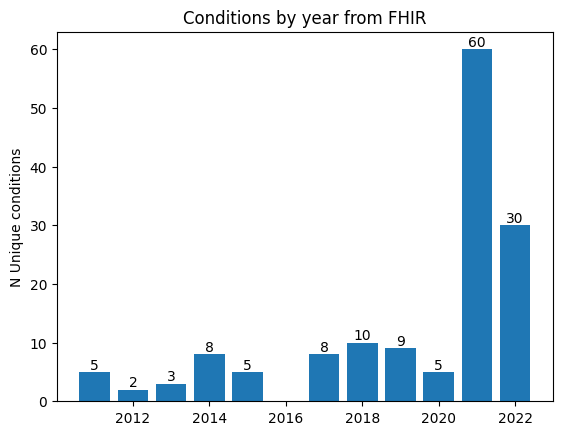

45    2011-09-21
48    2011-09-21
46    2011-09-21
43    2011-09-21
37    2011-09-21
47    2012-01-05
40    2012-01-05
199   2013-10-03
198   2013-10-03
185   2013-10-03
141   2014-02-09
118   2014-03-03
142   2014-03-13
131   2014-03-13
134   2014-03-13
69    2014-05-08
72    2014-05-09
68    2014-07-21
8     2015-01-09
6     2015-02-23
7     2015-02-23
161   2015-03-02
159   2015-03-08
59    2017-02-21
58    2017-03-07
107   2017-04-17
108   2017-04-17
112   2017-04-17
166   2017-08-25
168   2017-08-25
167   2017-08-25
12    2018-03-27
4     2018-03-27
22    2018-03-27
9     2018-04-02
15    2018-04-02
2     2018-04-02
17    2018-05-02
88    2018-06-05
67    2018-12-03
66    2018-12-03
0     2019-01-15
170   2019-01-16
176   2019-01-17
30    2019-03-12
29    2019-03-12
175   2019-07-15
162   2019-10-28
171   2019-11-20
169   2019-11-26
164   2020-03-02
172   2020-04-16
173   2020-04-16
163   2020-05-15
183   2020-10-01
193   2021-01-20
19    2021-04-02
74    2021-04-12
73    2021-04-

In [9]:
years = cr_meds['start_date_d'].dt.year.value_counts().reset_index(name="Medications")
bar = plt.bar(years['index'], years['Medications'])
plt.bar_label(bar)
plt.title('Conditions by year from FHIR')
plt.ylabel('N Unique conditions')
plt.show()
cr_meds['start_date_d'].dropna().sort_values()

In [15]:
# Run this to limit analysis to date range:
start_date = '2015-12-01'
end_date = '2023-04-21'

print(f'Filtering for dates...')
print(f'Before (FHIR, PCORnet, Chart Review) ', len(fhir_meds), ' ', len(pc_meds), ' ', len(cr_meds))
fhir_meds = fhir_meds[fhir_meds['authoredon_d'].between(start_date, end_date)]
pc_meds = pc_meds[pc_meds['rx_order_date_d'].between(start_date, end_date)]
# cr_meds = cr_meds[~(cr_meds['start_date_d'] < start_date)]
# cr_meds = cr_meds[~(cr_meds['start_date_d'] > end_date)]
# cr_cond = cr_cond[cr_cond['date_entered_d'].between(start_date, end_date)]
print(f'After (FHIR, PCORnet, Chart Review) ', len(fhir_meds), ' ', len(pc_meds), ' ', len(cr_meds))

Filtering for dates...
Before (FHIR, PCORnet, Chart Review)  55313   7789   214
After (FHIR, PCORnet, Chart Review)  51784   7789   214


# Code medications

In [16]:
cr_meds = drugUtil.add_ingredient_columns(cr_meds, 'medication_name').explode(['code', 'ingredient'])


KeyError: 'code'

In [ ]:
cr_meds

# Compare by name

In [19]:
cr_result = cr_meds[cr_meds['medication_name'].str.contains('aspirin', case=False)]

In [23]:
cr_result

,user_id,medication_name,rxcui (if avail),start_date,end_date,Source,entered_on,Notes:,"*If start_date not available, use ordered_on_date",start_date_d,ingredient,code
68,378622,aspirin 81 mg EC tablet,NaN,2014-07-21,NaT,"SnapShot, under Medications",NaT,NaN,NaN,2014-07-21,aspirin,1191
148,433846,aspirin 81 mg tablet,NaN,NaT,NaT,"SnapShot, under Medications",2011-12-15,Entered on: 12/15/11,NaN,NaT,aspirin,1191


# Build medication map

In [24]:
# fhir_meds_d = fhir_meds[fhir_meds['user_id'].isin(cr_demo['user_id'])]
# pc_meds_d = pc_meds[pc_meds['user_id'].isin(cr_demo['user_id'])]
# cr_meds_d = cr_meds.copy()

In [49]:
pc_meds_query[pc_meds_query['CODE_DESC'].str.contains('aspirin', case=False)]

def get_drug_codes(search_re, pc_meds_query, drugUtil):
    print('Processing search_query', search_re)
    codes = pc_meds_query[pc_meds_query['CODE_DESC'].str.contains(search_re, case=False)]['CODE'].tolist()
    ing_results = drugUtil.rxnormIngr[drugUtil.rxnormIngr['INGREDIENT'].str.contains(search_re, case=False)]
    related_meds = ing_results['RXCUI'].drop_duplicates().tolist()
    print(f'     found {len(related_meds)} meds containing this ingredient in rxnorm')
    ing_related_meds = ing_results['ING_RXCUI'].drop_duplicates().tolist()
    print(f'     found {len(ing_related_meds)} ingredients in rxnorm')
    codes.extend([*related_meds, *ing_related_meds])
    return list(set(codes))


def get_concept_codes(pc_meds_query, drugUtil, pc_concept_lbl=None, search_re=None):
    print('Processing concept_label', pc_concept_lbl)
    result_df = pc_meds_query[pc_meds_query['CONCEPT_LBL'].str.match(pc_concept_lbl, case=False)]
    result_df = drugUtil.add_ingredient_columns(result_df, 'CODE_DESC', new_code_column='ing_code', new_name_column='ing')
    result_df = result_df.explode(['ing_code','ing'])
    #     print(result_df.columns)
    codes = result_df['ing_code'].tolist()
    codes = codes.extend(result_df['CODE'].tolist())
    return result_df

drug_map = {}
print('seraching antiplatelets')
drug_map['antiplatelet'] = {
    'regex': 'aspirin|DIPYRIDAMOLE|CANGRELOR|AGGRENOX|ticagrelor|brilinta',
    'regex_ing': 'aspirin|ticagrelor|clopidogrel|dipyridamole',
    'codes': []
}
print('searching warfarin')
drug_map['warfarin'] = {
    'regex': 'farin',
    'regex_ing': 'warfarin',
    'codes': []
}
# print('searching corticosteroid')
# drug_map['corticosteroid'] = {
#     'regex': '',
#     'codes': []
# }
# print('dexamethasone')
# drug_map['dexamethasone'] = {
#     'regex': '',
#     'codes': []
# }



seraching antiplatelets
searching warfarin


In [50]:
pc_meds_query['CONCEPT_LBL'].value_counts()

CORTICOSTEROID          1985
ASPIRIN                  836
IMMUNOSUPPRESSANT        664
HEPARIN                  358
DEXAMETHASONE            297
LMW_HEPARIN              150
IVERMECTIN               113
THROMBOLYTIC_MED         109
FACTORXA_INHIBITOR        37
THROMBIN_INHIBITOR        36
ANTIPLATELET THERAPY      36
TOCILIZUMAB               29
SARILUMAB                 23
AZITHROMYCIN              19
IMDEVIMAB                 15
CASIRIVIMAB               15
SILTUXIMAB                13
VITAMINK_ANTAGONIST       13
REMDESIVIR                11
COLCHICINE                 9
ETESEVIMAB                 4
BAMLANIVIMAB               4
HYDROXYCHLOROQUINE         2
FLUVOXAMINE                1
BARICITINIB                1
Name: CONCEPT_LBL, dtype: int64

In [29]:
pc_meds_query[pc_meds_query['CONCEPT_LBL'] == 'ANTIPLATELET THERAPY']

,CONCEPT_ID,CONCEPT_LBL,CODETYPE,CODE,CODE_DESC
175,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,1116636,BRILINTA
176,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,1158988,DIPYRIDAMOLE INJECTABLE PRODUCT
177,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,1362081,ASPIRIN / DIPYRIDAMOLE ORAL CAPSULE [AGGRENOX]
178,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,151502,CEREBROVASE
179,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,152065,MODAPLATE
180,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,153258,PERSANTIN RETARD
181,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,1537040,ZONTIVITY
182,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,1656054,CANGRELOR INJECTABLE PRODUCT
183,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,1656055,CANGRELOR INJECTION
184,MD_ANTIPLT,ANTIPLATELET THERAPY,RXCUI,1656056,CANGRELOR 50 MG INJECTION


# Add med_coded column, representing true coded med

In [36]:
cr_meds['med_coded'] = np.nan
for drug in drug_map.keys():
    drug_filter = cr_meds['medication_name'].str.contains(drug_map[drug]['regex'], na=False, case=False)
    cr_meds['med_coded'] = np.where(drug_filter, drug, cr_meds['med_coded'])
dedup = cr_meds.drop_duplicates(['user_id', 'med_coded'])
dedup['med_coded'].value_counts(dropna=False)

nan             15
antiplatelet     2
Name: med_coded, dtype: int64

In [39]:
pc_meds['med_coded'] = np.nan
for drug in drug_map.keys():
    drug_filter = pc_meds['raw_rx_med_name'].str.contains(drug_map[drug]['regex'], na=False, case=False)
    pc_meds['med_coded'] = np.where(drug_filter, drug, pc_meds['med_coded'])
dedup = pc_meds.drop_duplicates(['user_id', 'med_coded'])
dedup['med_coded'].value_counts(dropna=False)

nan             390
antiplatelet     47
warfarin          9
Name: med_coded, dtype: int64

In [40]:
fhir_meds['med_coded'] = np.nan
for drug in drug_map.keys():
    drug_filter = fhir_meds['text'].str.contains(drug_map[drug]['regex'], na=False, case=False)
    fhir_meds['med_coded'] = np.where(drug_filter, drug, fhir_meds['med_coded'])
dedup = fhir_meds.drop_duplicates(['user_id', 'med_coded'])
dedup['med_coded'].value_counts(dropna=False)

/tmp/ipykernel_367/1409821033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fhir_meds['med_coded'] = np.nan
/tmp/ipykernel_367/1409821033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fhir_meds['med_coded'] = np.where(drug_filter, drug, fhir_meds['med_coded'])


nan             1102
antiplatelet     122
Name: med_coded, dtype: int64

In [43]:
fhir_meds

,user_id,uploaded_date,provider,medication_id,status,intent,medication_reference,text,authoredon,requester_display,recorder_display,course_of_therapy,dosage_text,dosage_patientinstruction,dosage_as_needed,dosage_route,dosage_method,dose_text,dose_quantity_value,dose_quantity_unit,start,repeats,quantity,quantity_unit,supply,supply_unit,authoredon_d,reference_id,coding_code,_merge,med_coded
0,375075,2022-08-11,openepic_shared_ucsf_health,e-ay2ty3jI96yIQH8OVccfMSOfHMCHk.RN0IbIYnrU-I3,active,order,Medication/edD6I8WguLcwetNZPfklM.ky12P0CvrbC2S9C89y8FxEqTs8ikYZVbmQ6aH.69S3DreN24zY8gk2wWY50vvG31qJ9U8ybpxw.0kiA-xQx1uk3,ranibizumab,2020-07-15T18:28:15Z,Melissa Deanne Neuwelt,Melissa Deanne Neuwelt,Short course (acute) therapy,NaN,NaN,NaN,Intravitreal,NaN,ordered,0.0,mg,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15 18:28:15+00:00,NaN,NaN,left_only,nan
1,375075,2022-08-11,openepic_shared_ucsf_health,e.tKigUz4ZhviB3MHMn5DJzlV7LqAQlh5JTw5WL5xOL43,active,order,Medication/eApsso8nJQzn.LgrTIOvb4BqqSswshN7RIHNgKU9K9VAFI32SpYSTk-ljYfQMzrEndqrlCp2sUDCY6.waqrnwZpM1PyNVjfi.hdcMk1-uFjc3,PROBIOTIC 4X ORAL,2019-12-30T22:23:32Z,NaN,Sarah Archenbronn,Short course (acute) therapy,Take 1 capsule by mouth Daily.,Take 1 capsule by mouth Daily.,f,Oral,Take,ordered,1.0,capsule,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30 22:23:32+00:00,NaN,NaN,left_only,nan
2,375075,2022-08-11,openepic_shared_ucsf_health,e2R9bXtqVRbU-1etdHoQYL8seLNCe-OTb4HEY-mnGQWs3,active,order,Medication/edD6I8WguLcwetNZPfklM.s67k1cHiEceWZxKbPdoJq.2SB0wDNs9my1zlFHGoDGNWJ9TypTzIA6bgP-Xx-uf8QFRIaHeXX8ApZebfWLU.QY3,ranibizumab,2021-03-23T16:29:37Z,Melissa Deanne Neuwelt,Melissa Deanne Neuwelt,Short course (acute) therapy,NaN,NaN,NaN,Intravitreal,NaN,ordered,0.0,mg,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-23 16:29:37+00:00,NaN,NaN,left_only,nan
3,375075,2022-08-11,openepic_shared_ucsf_health,e4JotmM6oXq2lZaoFz3TRxHotSDsg5H-tHU6bDSGN-Ok3,active,order,Medication/eK0HeIiQcXFVZYKRSnyIrQ.Z9mmpiWpK5HDfOBInThDqdC-uvL4bAyddLExR0vd0FQcw5fkq9W33aHbTdlhRvi0z2d3fU9YtFjDH4fvdqSwU3,"fish oil-omega-3 fatty acids 360-1,200 mg capsule",2019-12-30T22:23:32Z,NaN,Sarah Archenbronn,Short course (acute) therapy,Take 1 capsule by mouth 2 (two) times daily.,Take 1 capsule by mouth 2 (two) times daily.,f,Oral,Take,ordered,1.0,capsule,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30 22:23:32+00:00,NaN,NaN,left_only,nan
4,375075,2022-08-11,openepic_shared_ucsf_health,e5Rb3tSNOpiZHdEMlsW1Wn-cDYee9627sTh5G1Z9vorg3,active,order,Medication/e3lqtFJpVeTuaeBDBSUFXGlegOWkI.CbnbUZIUW8CVc8b.-F7hZyTcAa79SwE8xuxVrMj9EithebNmVG9urT3r781SBbrLFWRzsFlugbufpo3,atorvastatin 20 mg tablet,2021-10-26,Sunita Mutha,Sunita Mutha,Short course (acute) therapy,Take 1 tablet (20 mg total) by mouth daily,Take 1 tablet (20 mg total) by mouth daily,f,Oral,Take,ordered,20.0,mg,2021-10-26,2.0,90.0,tablet,90.0,90.0,2021-10-26 00:00:00+00:00,NaN,NaN,left_only,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31971,439617,2022-08-05,openepic_shared_kaiser_permanente_california_southern,edQSLhwpHFGjtcppdUheGVk4xfHLgKTLyqh8Zt7N6P.M3,active,order,Medication/eD0wfj6dv6.0-XvholAQs7pGm0mQuw48gOOzxpJdUZ5bipNdQ4lmum-F81nW71TRl4-wNGT12vZih4fJIEvR4h1-nxO4Ttlp0aqwFrjKEeIc3,traZODone 50 mg Tab,2022-05-04,"HENRY LAM TRAN DO, D.O.","HENRY LAM TRAN DO, D.O.",Short course (acute) therapy,Take 1 tablet by mouth daily at bedtime,Take 1 tablet by mouth daily at bedtime,f,Oral,Take,ordered,50.0,mg,2022-05-04,0.0,30.0,tablet,30.0,30.0,2022-05-04 00:00:00+00:00,NaN,NaN,left_only,nan
31972,439617,2022-08-05,openepic_shared_kaiser_permanente_california_southern,erP0IJ186RPuLFrOtpxOzFvqtVaPZLcxzvXpvwx.MD6g3,active,order,Medication/e2VxGzJpx-kOxUjUuYslJc5q0zH8gDpw8yWwCD10ztibvvDbr-Z.QEncLmkR8FhDzCvx2E67Mp0OXAoMwMfKH4BL-fYyQaScArnKsFgWp2VY3,HYDROcodone-Acetaminophen 5-325 mg Tab,2022-08-02,"NIRVI VIJAY SHAH DO, D.O.","NIRVI VIJAY SHAH DO, D.O.",Short course (acute) therapy,Take 1 tablet by mouth at bedtime as needed for severe pain . Do not ex

# Select subgroup to analyze

In [51]:
# Limit FHIR to PC provider

site_config = {
    'UCSFHEALTHPARTN': 'openepic_shared_ucsf_health',
    'UT1PARTNER': 'openepic_shared_university_of_utah_healthcare',
    'NY1PARTNER': 'openepic_shared_nyu_langone_medical_center',
    'SH2PARTNER': 'openepic_shared_sutter_health',
    'OS2PARTNER': 'openepic_shared_ochsner_health_system',
    'MF1PARTNER': 'openepic_shared_montefiore_medical_center',
    'BA1PARTNER': 'openepic_shared_baylor_scott_white'
}
pc_demo['provider'] = pc_demo['siteid'].replace(site_config)
pc_demo_m = pc_demo.drop_duplicates(['user_id', 'provider'])

print('All medications before filter', 'FHIR', len(fhir_meds), 'PC', len(pc_meds))
# fhir_meds_pc = fhir_meds.merge(pc_demo_m, left_on=['user_id', 'provider'], right_on=['user_id', 'pc_site'], how='inner')
# print('FHIR length after only keeping PC sites:', len(fhir_meds_pc))

# Add provider information to pc_meds
pc_meds_s = pc_meds.merge(pc_demo_m, on='user_id', how='left')

# Only select users in chart review
fhir_meds_s = fhir_meds[fhir_meds['user_id'].isin(cr_demo['user_id'])]
pc_meds_s = pc_meds_s[pc_meds_s['user_id'].isin(cr_demo['user_id'])]

# Only select UCSF provider
fhir_meds_s = fhir_meds_s[fhir_meds_s['provider'] == 'openepic_shared_ucsf_health']
pc_meds_s = pc_meds_s[pc_meds_s['provider'] == 'openepic_shared_ucsf_health']

print('After subgroup selection', 'FHIR', len(fhir_meds_s), 'PC', len(pc_meds_s))


All medications before filter FHIR 28531 PC 7789
After subgroup selection FHIR 212 PC 89


In [52]:
fhir_meds_s[fhir_meds_s['med_coded'] == 'aspirin']

,user_id,uploaded_date,provider,medication_id,status,intent,medication_reference,text,authoredon,requester_display,recorder_display,course_of_therapy,dosage_text,dosage_patientinstruction,dosage_as_needed,dosage_route,dosage_method,dose_text,dose_quantity_value,dose_quantity_unit,start,repeats,quantity,quantity_unit,supply,supply_unit,authoredon_d,reference_id,coding_code,_merge,med_coded


In [53]:
pc_meds_s['concept_lbl'].value_counts()

CORTICOSTEROID          48
IMMUNOSUPPRESSANT       14
HEPARIN                 10
ANTIPLATELET THERAPY     8
DEXAMETHASONE            6
ASPIRIN                  1
AZITHROMYCIN             1
FACTORXA_INHIBITOR       1
Name: concept_lbl, dtype: int64

In [19]:
cr_meds[cr_meds['med_coded'] == 'aspirin']

,user_id,medication_name,rxcui (if avail),start_date,end_date,Source,Notes:,"*If start_date not available, use ordered_on_date",start_date_d,med_coded
68,378622,aspirin 81 mg EC tablet,NaN,2014-07-21,NaT,"SnapShot, under Medications",NaN,NaN,2014-07-21,aspirin
148,433846,aspirin 81 mg tablet,NaN,NaT,NaT,"SnapShot, under Medications",Entered on: 12/15/11,NaN,NaT,aspirin


# Uncharacterized

In [52]:
# Build drug map

# drug_map = dict()
# drug_map['aspirin']['codes'] = pc_meds_query[pc_meds_query['CONCEPT_LBL'] == 'ASPIRIN']['CODE'].drop_duplicates().tolist()
# drug_map['aspirin']['codes'].extend(get_drug_codes(['aspirin'], pc_meds_query, drugUtil))
# drug_map['aspirin']['codes'] = list(set(drug_map['aspirin']['codes']))

# drug_map['corticosteroid'] = pc_meds_query[pc_meds_query['CONCEPT_LBL'] == 'CORTICOSTEROID']['CODE'].drop_duplicates().tolist()
# drug_map['immunosuppressant'] = pc_meds_query[pc_meds_query['CONCEPT_LBL'] == 'IMMUNOSUPPRESSANT']['CODE'].drop_duplicates().tolist()
# drug_map['antiplatelets'] = pc_meds_query[pc_meds_query['CONCEPT_LBL'] == 'ANTIPLATELET THERAPY']['CODE'].drop_duplicates().tolist()
# drug_map['antiplatelets'].extend(drug_map['aspirin'])

# drug_map['warfarin'] = pc_meds_query[pc_meds_query['CONCEPT_LBL'] == 'VITAMINK_ANTAGONIST']['CODE'].drop_duplicates().tolist()
# drug_map['warfarin'].extend(get_drug_codes(['farin'], pc_meds_query, drugUtil))
# drug_map['warfarin'] = list(set(drug_map['warfarin']))

# drug_map['azithromycin'] = pc_meds_query[pc_meds_query['CONCEPT_LBL'] == 'AZITHROMYCIN']['CODE'].drop_duplicates().tolist()
# drug_map['azithromycin'].extend(get_drug_codes(['azithromycin', 'zithro'], pc_meds_query, drugUtil))
# drug_map['azithromycin'] = list(set(drug_map['azithromycin']))



In [54]:
pc_meds

,v1,user_id,prescribingid,concept_id,concept_lbl,rx,rx_type,rx_order_date,rx_start_date,rx_end_date,rx_days_supply,rx_refills,raw_rx_med_name,encounterid,query_date,datamartid
0,26,502639,{CCB4BB82-4C07-4981-BAB9-8A7E43BF96D1},MD_CORTICSTD,CORTICOSTEROID,966522,RXCUI,23oct2017,23oct2017,19jan2018,1.0,3.0,BUDESONIDE 180 MCG/ACT IN AEPB,886152381,23jan2023,SUTTER
1,26,502639,{B9E5AF5B-7450-4892-A82D-626AAD013DA8},MD_CORTICSTD,CORTICOSTEROID,966540,RXCUI,28dec2018,28dec2018,NaN,1.0,3.0,BECLOMETHASONE DIPROPIONATE 80 MCG/ACT IN AERS,952334898,23jan2023,SUTTER
2,26,502639,{C3AF0BC2-0F3F-4B7C-AA4C-9BD6FD87F644},MD_CORTICSTD,CORTICOSTEROID,966540,RXCUI,20dec2018,20dec2018,28dec2018,NaN,3.0,BECLOMETHASONE DIPROPIONATE 80 MCG/ACT IN AERS,947684175,23jan2023,SUTTER
3,26,502639,{2CC6A9B0-E44C-49BC-B4C6-0EDEE64D37D4},MD_CORTICSTD,CORTICOSTEROID,966540,RXCUI,17oct2017,17oct2017,19jan2018,NaN,3.0,BECLOMETHASONE DIPROPIONATE 80 MCG/ACT IN AERS,885230200,23jan2023,SUTTER
4,117,545573,76186567-1,MD_LMW_HEPARIN,LMW_HEPARIN,854235,RXCUI,25nov2020,25nov2020,25nov2020,NaN,NaN,Enoxaparin Sodium Inj 40 MG/0.4M,UTAH20074378,12jan2023,C4UU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784,43448,520958,10325248-1,MD_CORTICSTD,CORTICOSTEROID,1085754,RXCUI,19dec2018,19dec2018,19dec2018,NaN,NaN,Triamcinolone Acetonide Inj Susp 40 MG/M,UTAH14344938,12jan2023,C4UU
7785,46703,542317,62065465,MD_DEXAMETH,DEXAMETHASONE,1116927,RXCUI,20aug2018,20aug2018,NaN,NaN,NaN,NaN,43663484,03feb2023,C8NYU
7786,46703,542317,60377948,MD_CORTICSTD,CORTICOSTEROID,1359779,RXCUI,07feb2020,07feb2020,11jul2022,NaN,0.0,NaN,43449328,03feb2023,C8NYU
7787,46703,542317,59574810,MD_DEXAMETH,DEXAMETHASONE,1116927,RXCUI,20aug2018,20aug2018,20aug2018,NaN,NaN,NaN,43663484,03feb2023,C8NYU


In [15]:
pc_meds['concept_lbl'].value_counts(dropna=False)

CORTICOSTEROID          2111
IMMUNOSUPPRESSANT       1895
HEPARIN                 1646
DEXAMETHASONE            717
ASPIRIN                  488
LMW_HEPARIN              254
FACTORXA_INHIBITOR       234
AZITHROMYCIN             167
VITAMINK_ANTAGONIST      143
THROMBOLYTIC_MED          97
ANTIPLATELET THERAPY      79
COLCHICINE                62
HYDROXYCHLOROQUINE        49
THROMBIN_INHIBITOR        44
IVERMECTIN                 4
TOCILIZUMAB                3
REMDESIVIR                 2
CASIRIVIMAB                2
IMDEVIMAB                  2
BAMLANIVIMAB               1
ETESEVIMAB                 1
Name: concept_lbl, dtype: int64

# Demographics Only

In [16]:
fhir_demo = fhirUtil.demographics.drop_duplicates(subset="user_id")
m_demo = pc_demo.drop_duplicates(subset="user_id").merge(fhir_demo.drop_duplicates(subset="user_id"), on="user_id", indicator=True, how="outer")
common_users = m_demo[m_demo['_merge'] == 'both']
common_users_cr = common_users[common_users['user_id'].isin(cr_demo['user_id'])]
print(m_demo['_merge'].value_counts())
print('chart review users: ', len(common_users_cr))


right_only    844
both          618
left_only      11
Name: _merge, dtype: int64
chart review users:  15


# PCORNET Medications Analysis

In [24]:
# fhir_meds = fhirUtil.get_coded_medications(drugUtil)
fhir_meds = fhirUtil.medications
fhir_meds['authoredon_d'] = pd.to_datetime(fhir_meds['authoredon'])
pc_meds = pc_meds
ccs_meds = ccsUtil.medications
print('FHIR meds loaded:', len(fhir_meds))

FHIR meds loaded: 31976


In [23]:
len(pc_meds)
# len(ccs_meds.explode('rxcui_ing'))

8001

# Compare PCORNET and FHIR wrt Chart Review

In [54]:
# Limit FHIR to PC provider

site_config = {
    'UCSFHEALTHPARTN': 'openepic_shared_ucsf_health',
    'UT1PARTNER': 'openepic_shared_university_of_utah_healthcare',
    'NY1PARTNER': 'openepic_shared_nyu_langone_medical_center',
    'SH2PARTNER': 'openepic_shared_sutter_health',
    'OS2PARTNER': 'openepic_shared_ochsner_health_system',
    'MF1PARTNER': 'openepic_shared_montefiore_medical_center',
    'BA1PARTNER': 'openepic_shared_baylor_scott_white'
}
pc_demo['pc_site'] = pc_demo['siteid'].replace(site_config)
pc_demo_m = pc_demo.drop_duplicates(['user_id', 'pc_site'])
print('All medications before filter', 'FHIR', len(fhir_meds), 'PC', len(pc_meds))
fhir_meds_pc = fhir_meds.merge(pc_demo_m, left_on=['user_id', 'provider'], right_on=['user_id', 'pc_site'], how='inner')
print('FHIR length after only keeping PC sites:', len(fhir_meds_pc))
fhir_meds_a = fhir_meds_pc[fhir_meds_pc['user_id'].isin(cr_demo['user_id'])]
pc_meds_a = pc_meds[pc_meds['user_id'].isin(cr_demo['user_id'])]
print('After selecting CR users and keeping only FHIR PC sites', 'FHIR', len(fhir_meds_a), 'PC', len(pc_meds_a))
print('After filtering only UCSF FHIR', len(fhir_meds_a), 'PC', len(pc_meds_a))
pc_demo_ucsf = pc_demo[pc_demo['pc_site'] == 'openepic_shared_ucsf_health']



All medications before filter FHIR 28531 PC 7789
FHIR length after only keeping PC sites: 12134
After selecting CR users and keeping only FHIR PC sites FHIR 212 PC 89
After filtering only UCSF FHIR 212 PC 89


In [55]:
pc_meds_a['user_id'].value_counts()

457587    35
457363    17
433846    13
462377    11
35829      9
378622     3
458578     1
Name: user_id, dtype: int64

In [56]:
fhir_meds_a['user_id'].value_counts()

462377    82
35829     42
457363    31
457587    15
477473    13
454596     9
378622     6
458578     5
433846     3
462421     3
481303     2
458871     1
Name: user_id, dtype: int64

In [57]:
cr_meds['user_id'].value_counts()

457363    39
458578    28
457587    27
35829     24
462377    23
378622    17
454596    12
465182    12
477473    11
433846     9
459181     8
462421     8
480918     5
481303     3
458871     2
Name: user_id, dtype: int64

In [152]:
fhirUtil.medications_raw[fhirUtil.medications_raw['user_id'] == 457363]

,user_id,uploaded_date,provider,id,status,intent,medication_reference,text,authoredon,requester_display,recorder_display,course_of_therapy,dosage_text,dosage_patientinstruction,dosage_as_needed,dosage_route,dosage_method,dose_text,dose_quantity_value,dose_quantity_unit,start,repeats,quantity,quantity_unit,supply,supply_unit,med_ref_id
10335,457363,2022-09-11,openepic_shared_ucsf_health,e.biTr1ZY.gbs.czm-y8V1VsM0kd1syOU8XWdx.aQO4k3,active,order,Medication/e9jpRF4llDbaUdVbS.xbf.YYr5.QN049EY8yof3gbgG-F0T.54pDdPRi1UL7h3VmbBEc5XzdeK4jdTDL-qf0.j6ODLp70nW7lZPCZwR0.wpM3,metaxalone 800 mg tablet,2022-02-10T16:50:07Z,NaN,Martha H,Short course (acute) therapy,Take 800 mg by mouth in the morning and 800 mg in the evening and 800 mg before bedtime.,Take 800 mg by mouth in the morning and 800 mg in the evening and 800 mg before bedtime.,f,Oral,Take,ordered,800.0,mg,NaN,NaN,NaN,NaN,NaN,NaN,e9jpRF4llDbaUdVbS.xbf.YYr5.QN049EY8yof3gbgG-F0T.54pDdPRi1UL7h3VmbBEc5XzdeK4jdTDL-qf0.j6ODLp70nW7lZPCZwR0.wpM3
10336,457363,2022-09-11,openepic_shared_ucsf_health,e1Ah0OaXx.5M0Foj7p.48TAkuvg3q-EJrNCyb8l2sss83,active,order,Medication/elUhn28a-G4qy4H-CTUAdLJCzWyUbbFyhBHg7hlao8QNA97H.4wHfFiLrtSCzwUyBQ3OtlIsNuh1QL-0uaiPyRz.4lijZwozsemW56sfZYvw3,CHLOROPHYLL ORAL,2022-03-03T16:38:38Z,NaN,Teresa Phyllis Jones,Short course (acute) therapy,Take 1 capsule by mouth every evening (dosage unknown)\r\n,Take 1 capsule by mouth every evening (dosage unknown)\r\n,f,Oral,Take,ordered,1.0,capsule,NaN,NaN,NaN,NaN,NaN,NaN,elUhn28a-G4qy4H-CTUAdLJCzWyUbbFyhBHg7hlao8QNA97H.4wHfFiLrtSCzwUyBQ3OtlIsNuh1QL-0uaiPyRz.4lijZwozsemW56sfZYvw3
10337,457363,2022-09-11,openepic_shared_ucsf_health,e4KvRfYacJ8aTY0DipQGo7JDhtsRohnzBTr0u-S0ngeQ3,active,order,Medication/eGXA7.33pDDtDithJJ1amwNtOhAYQaJIfSg5w-FoF9uOOjTJ-6icjGgQIDPJ4BBHIpnee8Jx0tYJ.5ap-u2QLta9oTX4chegC1QSJOysFrnc3,amLODIPine 10 mg tablet,2022-02-10T16:50:07Z,NaN,Martha H,Short course (acute) therapy,Take 10 mg by mouth every evening,Take 10 mg by mouth every evening,f,Oral,NaN,ordered,10.0,mg,NaN,NaN,NaN,NaN,NaN,NaN,eGXA7.33pDDtDithJJ1amwNtOhAYQaJIfSg5w-FoF9uOOjTJ-6icjGgQIDPJ4BBHIpnee8Jx0tYJ.5ap-u2QLta9oTX4chegC1QSJOysFrnc3
10338,457363,2022-09-11,openepic_shared_ucsf_health,e5f4Jdks3uJe3tajaYeGkdPy1cGwn657gh-Ble3wZswI3,active,order,Medication/eFt5iHAtZsLRGPif35p576qO99s-FcUwrCH7lr1f.W4y.85U19clnz0LJK8LnpLMKB1-2-Tjn6MWmwqUv.55X-1SZrM9NCloNq5DlAqZF1JU3,gabapentin 600 mg tablet,2022-07-29,Lori A Reisner,Lori A Reisner,Short course (acute) therapy,Take 1 tablet (600 mg total) by mouth in the morning and 1 tablet (600 mg total) in the evening and 1 tablet (600 mg total) before bedtime.,Take 1 tablet (600 mg total) by mouth in the morning and 1 tablet (600 mg total) in the evening and 1 tablet (600 mg total) before bedtime.,f,Oral,Take,calculated,600.0,mg,2022-07-29,2.0,90.0,tablet,30.0,30.0,eFt5iHAtZsLRGPif35p576qO99s-FcUwrCH7lr1f.W4y.85U19clnz0LJK8LnpLMKB1-2-Tjn6MWmwqUv.55X-1SZrM9NCloNq5DlAqZF1JU3
10339,457363,2022-09-11,openepic_shared_ucsf_health,e5f4Jdks3uJe3tajaYeGkdPy1cGwn657gh-Ble3wZswI3,active,order,Medication/eFt5iHAtZsLRGPif35p576qO99s-FcUwrCH7lr1f.W4y.85U19clnz0LJK8LnpLMKB1-2-Tjn6MWmwqUv.55X-1SZrM9NCloNq5DlAqZF1JU3,gabapentin 600 mg tablet,2022-07-29,Lori A Reisner,Lori A Reisner,Short course (acute) therapy,Take 1 tablet (600 mg total) by mouth in the morning and 1 tablet (600 mg total) in the evening and 1 tablet (600 mg total) before bedtime.,Take 1 tablet (600 mg total) by mouth in the morning and 1 tablet (600 mg total) in the evening and 1 tablet (600 mg total) before bedtime.,f,Oral,Take,admin-amount,1.0,tablet,2022-07-29,2.0,90.0,tablet,30.0,30.0,eFt5iHAtZsLRGPif35p576qO99s-FcUwrCH7lr1f.W4y.85U19clnz0LJK8LnpLMKB1-2-Tjn6MWmwqUv.55X-1SZrM9NCloNq5DlAqZF1JU3
10340,457363,2022-09-11,openepic_shared_ucsf_health,e5f4Jdks3uJe3tajaYeGkdPy1cGwn657gh-Ble3wZswI3,active,order,Medication/eFt5iHAtZsLRGPif35p576qO99s-FcUwrCH7lr1f.W4y.85U19clnz0LJK8LnpLMKB1-2-Tjn6MWmwqUv.55X-1SZrM9NCloNq5DlAqZF1JU3,gabapentin 600 mg tablet,2022-07-29,Lo

# Compare PCORNET and FHIR

In [36]:
comparison_config = [
    {
        'title': 'Insulin', 
        'codes': [ 400008,  253182,  253182,  253182,  253182,  253182,  274783,
        274783,  139825,  253182,  253182,  274783,  253182,  253182,
        400008,  400008,   86009,   86009,   86009,  314684,   86009,
         86009, 1605101,   86009, 1670007,  274783, 1605101, 1605101,
        253182,  253182,  253182,  253182, 1670007,   51428,  274783,
        253182, 1670007,   86009,   86009,  274783,  274783,  274783,
        274783,  400008,  274783, 1605101,  253182,  274783,  139825,
         86009,   51428, 1605101,  253182,   86009,  274783,   86009,
       1670007, 1605101,  253182,  253182,  253182,  253182,   86009,
       1670007,   51428, 1605101,  253182,   51428,  253182,  253182,
        314684,   86009,  253182,   86009, 1605101,   51428,  352385,
         86009,   51428,  352385,   86009,  314684,   86009,   86009,
         86009,  314684,   86009,  139825,  139825,  274783,  274783,
        314684,   86009,  314684,   86009, 1605101,  352385,   86009,
       1670007, 1670007, 1605101,   51428,  253182,  253182,  274783,
        274783,  274783,   86009,  314684,   86009,   86009,   86009,
         51428,  274783,   86009,   86009,   86009,  274783,  274783,
        253182, 1605101,  352385,   51428,   86009,   51428,  314684,
         51428,   86009, 1605101,  253182,   51428,   51428, 1670007,
        274783,  253182]
    },
    {
        'title': 'Furosemide',
        'codes': [4063],
    },
    {
        'title': 'levothyroxin',
        'codes': [10582],
    },
    {
        'title': 'Statins',
        'codes': [83367, 301542, 41127, 42463, 36567]
    },
    {
        'title': 'Asthma',
        'codes': [41126, 435]
    },
    {
        'title': 'Depression',
        'codes': [42347, 36437, 321988, 4493, 39786, 72625, 10737, 2418, 32937]
    },
    {
        'title': 'Aspirin',
        'codes': [1191]
    },
    {
        'title': 'Hypertension',
        'codes': [29046, 52175, 17767, 5487, 9997, 69749]
    },
    {
        'title': 'Allergy',
        'codes': [41126, 20610, 28889, 88249, 87636, 356887, 5553]
    },
    {
        'title': 'OCP',
        'codes': [4124, 6373, 8727, 14584, 7514]
    },
    {
        'title': 'Sleep',
        'codes': [6711, 10737, 39993, 704]
    },
    {
        'title': 'Vitamins',
        'codes': [2418, 278, 11246, 11256, 11248, 42954,  8308, 11258, 42781, 11251]
    },
    {
        'title': 'Anxiety',
        'codes': [596, 2598, 6470]
    },
    {
        'title': 'Anticoagulation',
        'codes': [1364430, 11289, 1114195, 1599538, 5224, 67109, 67108]
    }
]


In [37]:
def compare_medications(codes, first, second, third, first_field, second_field, third_field):
    
    first_filter = first[first_field].isin(codes)
    first_s = first[first_filter].drop_duplicates(subset='user_id')
    print(len(first))
    first_s_no = common_users[~common_users["user_id"].isin(first_s['user_id'])].drop_duplicates(subset='user_id')
    
    second_filter = second[second_field].isin(codes)
    second_s = second[second_filter].drop_duplicates(subset="user_id")    
    second_s_no = common_users[~common_users["user_id"].isin(second_s['user_id'])].drop_duplicates(subset='user_id')
    
    third_filter = third[third_field].isin(codes)
    third_s = third[third_filter].drop_duplicates(subset="user_id")    
    third_s_no = common_users[~common_users["user_id"].isin(third_s['user_id'])].drop_duplicates(subset='user_id')
    
    
    f_s_m = first_s.merge(second_s, on="user_id", how="outer", indicator='f_s_m')
    all_m = f_s_m[f_s_m['f_s_m'] == 'both'].merge(third_s, on="user_id", how="outer", indicator="all_m")
    s_t_m = second_s.merge(third_s, on="user_id", how="outer", indicator="s_t_m")
    
    any_yes = pd.concat([first_s, second_s, third_s]).drop_duplicates('user_id')
    all_no = common_users[~common_users['user_id'].isin(any_yes['user_id'])]
#     f_s_no = first_s_no.merge(second_s_no, on="user_id", how="inner")
#     all_no = f_s_no.merge(third_s_no, on="user_id", how="inner")
        
    all_positive = all_m[all_m['all_m']=='both']
    first_only = first_s
    second_only = second_s
    third_only = third_s
    
    r = {
        'all_yes_len': len(all_positive),
        'first_only_len': len(first_only),
        'second_only_len': len(second_only),
        'first_second_only_len': len(first_s.merge(second_s, on="user_id", how="inner")),
        'third_only_len': len(third_only),
        'first_third_only_len': len(first_s.merge(third_s, on="user_id", how="inner")),
        'second_third_only_len': len(second_s.merge(third_s, on="user_id", how="inner")),
        'all_negative_len': len(all_no),
        'any_yes_len': len(any_yes),
        'any_no_len': len(all_no)-len(any_yes),
        'total_len': len(common_users)
    }
    return r
    
pc_meds_c = pc_meds[pc_meds['user_id'].isin(common_users_cr['user_id'])]
fhir_meds_c = fhir_meds[fhir_meds['user_id'].isin(common_users_cr['user_id'])]
cr_meds_c = ccs_meds[ccs_meds['user_id'].isin(common_users_cr['user_id'])]
compare_medications(comparison_config[0]['codes'], first=ccs_meds_c, second=fhir_meds_c, third=pc_meds_c,
                    first_field="rxcui_ing", second_field="coding_code", third_field="rxcui_ing")



1318


{'all_yes_len': 0,
 'first_only_len': 4,
 'second_only_len': 1,
 'first_second_only_len': 0,
 'third_only_len': 20,
 'first_third_only_len': 1,
 'second_third_only_len': 0,
 'all_negative_len': 594,
 'any_yes_len': 24,
 'any_no_len': 570,
 'total_len': 618}

In [38]:
pc_meds_c = pc_meds[pc_meds['user_id'].isin(common_users['user_id'])]
fhir_meds_c = fhir_meds[fhir_meds['user_id'].isin(common_users['user_id'])]
def getComparisonTable(comparison_config):
    result = []
    for config in comparison_config:
        print('Processing ', config['title'])
        comp = compare_medications(config['codes'], ccs_meds_c, fhir_meds_c, pc_meds_c, first_field="rxcui_ing", second_field="coding_code", third_field="rxcui_ing")
        if comp['any_yes_len'] == 0: comp['any_yes_len'] = 0.1
        if comp['any_no_len'] == 0: comp['any_no_len'] = 0.1

        resultRow = {
            'title': config['title'],
            'ALL Pos': comp['all_yes_len'],
            '%ALL': round((comp['all_yes_len']*100)/comp['any_yes_len']),
            'ANY Pos': round(comp['any_yes_len']),
            '%ANY': round((comp['any_yes_len']*100)/comp['total_len']),
            'CCS Pos': comp['first_only_len'],
            '%C': round((comp['first_only_len']*100)/comp['any_yes_len']),
            'FHIR Pos': comp['second_only_len'],
            '%F': round((comp['second_only_len']*100)/comp['any_yes_len']),
            'PC Pos': comp['third_only_len'],
            '%P': round((comp['third_only_len']*100)/comp['any_yes_len']),
            'CF Pos': comp['first_second_only_len'],
            '%CF': round((comp['first_second_only_len']*100)/comp['any_yes_len']),
            'CP Pos': comp['first_third_only_len'],
            '%CP': round((comp['first_third_only_len']*100)/comp['any_yes_len']),
            'FP Pos': comp['second_third_only_len'],
            '%FP': round((comp['second_third_only_len']*100)/comp['any_yes_len']),
            'ALL Negative': comp['all_negative_len'],
            '%A': round((comp['all_negative_len']*100)/(comp['any_no_len']))
        }
        result.append(resultRow)
    result_df = pd.DataFrame(result)
    return result_df

t = getComparisonTable(comparison_config)

Processing  Insulin
1318
Processing  Furosemide
1318
Processing  levothyroxin
1318
Processing  Statins
1318
Processing  Asthma
1318
Processing  Depression
1318
Processing  Aspirin
1318
Processing  Hypertension
1318
Processing  Allergy
1318
Processing  OCP
1318
Processing  Sleep
1318
Processing  Vitamins
1318
Processing  Anxiety
1318
Processing  Anticoagulation
1318


In [39]:
ccs_meds

,Unnamed: 0,index_orig,user_id,site,submitted_at,custom_entry,medication_name,brand_name,full_generic_name,product_name,sxdg_name,rxcui,generic_rxcui,sxdg_rxcui,route,dosage_form,strength,currently_taking,as_needed,frequency_number,frequency_every,frequency_unit,frequency_times_per_unit,variable_basis,reason,index,rxcui_ing,ing_name
0,0,0,14,covid,2021-09-27,True,ASPIRIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,not known,NaN,0,1191.0,['aspirin']
1,1,1,14,covid,2021-09-27,False,Atorvastatin (Oral Pill),NaN,atorvastatin 40 MG Oral Tablet,atorvastatin 40 MG Oral Tablet,atorvastatin Pill,617311.0,NaN,1158285.0,Oral Pill,Oral Tablet,40 mg,True,False,1.0,1.0,day,NaN,NaN,NaN,1,83367.0,NaN
2,2,2,14,covid,2021-09-27,False,Dofetilide (Oral Pill),NaN,dofetilide 0.125 MG Oral Capsule,dofetilide 0.125 MG Oral Capsule,dofetilide Pill,310003.0,NaN,1160621.0,Oral Pill,Oral Capsule,0.125 mg,True,False,3.0,12.0,hour,NaN,NaN,NaN,2,49247.0,NaN
3,3,3,14,covid,2021-09-27,False,ELIQUIS (Oral Pill),ELIQUIS,apixaban 5 MG Oral Tablet,apixaban 5 MG Oral Tablet [Eliquis],Eliquis Pill,1364447.0,1364445.0,1364440.0,Oral Pill,Oral Tablet,5 mg,True,False,1.0,12.0,hour,NaN,NaN,Afib,3,1364430.0,NaN
4,4,4,14,covid,2021-09-27,False,Ezetimibe (Oral Pill),NaN,ezetimibe 10 MG Oral Tablet,ezetimibe 10 MG Oral Tablet,ezetimibe Pill,349556.0,NaN,1163794.0,Oral Pill,Oral Tablet,10 mg,True,False,1.0,1.0,day,NaN,NaN,NaN,4,341248.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143867,132078,2235678,556213,BA1,2021-12-04,True,Cloidogrel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75mg,True,False,1.0,NaN,day,NaN,NaN,NaN,132078,NaN,NaN
143868,132079,2235679,556213,BA1,2021-12-04,False,Lansoprazole (Oral Disintegrating),NaN,lansoprazole 15 MG Disintegrating Oral Tablet,lansoprazole 15 MG Disintegrating Oral Tablet,lansoprazole Disintegrating Oral Product,351261.0,NaN,1295364.0,Oral Disintegrating,Disintegrating Oral Tablet,15 mg,True,False,2.0,NaN,day,NaN,NaN,NaN,132079,17128.0,NaN
143869,132080,2235680,556213,BA1,2021-12-04,False,Levothyroxine (Oral Pill),NaN,levothyroxine sodium 0.075 MG Oral Capsule,levothyroxine sodium 0.075 MG Oral Capsule,levothyroxine Pill,905458.0,NaN,1602745.0,Oral Pill,Oral Capsule,0.075 mg,True,False,1.0,NaN,day,NaN,NaN,NaN,132080,10582.0,NaN
143870,132081,2235681,556213,BA1,2021-12-04,False,Losartan (Oral Pill),NaN,losartan potassium 100 MG Oral Tablet,losartan potassium 100 MG Oral Tablet,losartan Pill,979480.0,NaN,1165343.0,Oral Pill,Oral Tablet,100 mg,True,False,1.0,NaN,day,NaN,NaN,NaN,132081,52175.0,NaN


In [40]:
grey_columns = [c for c in t.columns if c.startswith('%')]
red_columns = ['ALL Negative']
def highlight_cols(x):
    df = x.copy()
    df.loc[:, :] = 'background-color: none'
    df[grey_columns] = 'color: grey'
    df[red_columns] = 'color: red'
    return df 
display(t.style.apply(highlight_cols, axis = None))

,title,ALL Pos,%ALL,ANY Pos,%ANY,CCS Pos,%C,FHIR Pos,%F,PC Pos,%P,CF Pos,%CF,CP Pos,%CP,FP Pos,%FP,ALL Negative,%A
0,Insulin,0,0,24,4,4,17,1,4,20,83,0,0,1,4,0,0,594,104
1,Furosemide,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,618,100
2,levothyroxin,1,2,51,8,36,71,12,24,18,35,6,12,8,16,2,4,567,110
3,Statins,1,1,110,18,59,54,42,38,33,30,10,9,7,6,8,7,508,128
4,Asthma,1,1,87,14,38,44,38,44,28,32,8,9,4,5,6,7,531,120
5,Depression,3,2,160,26,81,51,74,46,38,24,18,11,11,7,7,4,458,154
6,Aspirin,1,1,81,13,25,31,32,40,38,47,6,7,4,5,5,6,537,118
7,Hypertension,4,3,126,20,70,56,46,37,38,30,16,13,9,7,7,6,492,134
8,Allergy,3,2,131,21,67,51,62,47,31,24,19,15,6,5,7,5,487,137
9,OCP,0,0,24,4,9,38,10,42,7,29,0,0,1,4,1,4,594,104


,v1,user_id,concept_id,concept_lbl,medadminid,rx,rx_type,medadmin_start_date,medadmin_stop_date,encounterid,query_date,datamartid,rxcui_ing
268,234,544931,MD_CORTICSTD,CORTICOSTEROID,17313308,859419.0,RX,10jul2019,NaN,UTAH15900944,13jun2022,C4UU,301542
1133,405,27061,MD_CORTICSTD,CORTICOSTEROID,28462131,617310.0,RX,24sep2020,NaN,4011391,17aug2022,C3UCSF,83367
2307,953,516563,MD_ASPIRIN,ASPIRIN,16737907,617310.0,RX,15aug2018,NaN,UTAH13415201,13jun2022,C4UU,83367
4170,1172,507764,MD_ASPIRIN,ASPIRIN,7B945B67-A69E-4C82-8F51-C8582B146142,617310.0,RX,27jun2020,27jun2020,1040410132,14jun2022,SUTTER,83367
4348,1291,552251,MD_ASPIRIN,ASPIRIN,24553816,617314.0,RX,30aug2018,NaN,31962619,05jul2022,C8NYU,83367
6640,2989,40818,MD_ASPIRIN,ASPIRIN,55527174,617311.0,RX,27nov2016,NaN,51302025,17aug2022,C3UCSF,83367
13873,3689,523036,MD_CORTICSTD,CORTICOSTEROID,8bf2bdab-f418-40aa-b1cd-919da8e029e7,617310.0,RX,01may2018,NaN,0E51489E7C227BF168D76F024DC731A8,17may2022,C6BAY,83367
14614,4159,542618,MD_CORTICSTD,CORTICOSTEROID,128660673,859749.0,RX,27may2021,30may2021,32339942,05jul2022,C8NYU,301542
17664,5101,42016,MD_CORTICSTD,CORTICOSTEROID,13671784,617311.0,RX,08sep2017,NaN,64154960,17aug2022,C3UCSF,83367
17984,5328,502638,MD_ASPIRIN,ASPIRIN,4EBCD178-7C0C-48F0-A26A-ED303BAB2597,312961.0,RX,05jul2019,05jul2019,979861582,14jun2022,SUTTER,36567


In [111]:
ccs_meds[ccs_meds['custom_entry'] == True]

,user_id,site,submitted_at,custom_entry,medication_name,brand_name,full_generic_name,product_name,sxdg_name,rxcui,generic_rxcui,sxdg_rxcui,route,dosage_form,strength,currently_taking,as_needed,frequency_number,frequency_every,frequency_unit,frequency_times_per_unit,variable_basis,reason,rxcui_ing,ing_name
0,14,covid,2021-09-27,True,ASPIRIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,not known,NaN,1191,[aspirin]
49,61,covid19,2021-11-30,True,statin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20mg,True,False,0.0,0.0,day,NaN,NaN,NaN,NaN,NaN
691,615,ucsfhealth,2021-12-07,True,Small Dose Aspirin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81 mg,False,False,2.0,1.0,day,NaN,NaN,NaN,1191,[aspirin]
776,629,covid19,2021-11-24,True,ASPIRIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,not known,NaN,1191,[aspirin]
846,782,covid19,2021-12-08,True,ASPIRIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81mg,False,False,1.0,1.0,day,NaN,NaN,NaN,1191,[aspirin]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235620,555962,BA1,2021-12-03,True,Acidophilus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100 million,True,False,1.0,24.0,hour,NaN,NaN,NaN,NaN,NaN
2235630,555991,BA1,2021-12-02,True,B12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000 mcg,True,False,1.0,7.0,day,NaN,NaN,NaN,NaN,NaN
2235662,556109,BA1,2021-12-08,True,doxycycline hyclate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100 mg,True,False,2.0,2.0,hour,NaN,NaN,NaN,NaN,NaN
2235668,556123,BA1,2021-12-09,True,Albuterol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inhaler,True,True,0.0,0.0,hour,NaN,NaN,NaN,435,[albuterol]


In [151]:
ccs_meds['rxcui_ing'].value_counts(dropna=False)

NaN          13255
10582.0       4370
1191.0        3511
83367.0       3293
41126.0       3190
             ...  
149.0            1
1433693.0        1
6142.0           1
139953.0         1
4678.0           1
Name: rxcui_ing, Length: 1152, dtype: int64

# 2-set comparison

In [ ]:
def compare_medications(codes, left, right, left_field, right_field):
    
    left_filter = left[left_field].isin(codes)
    left_s = left[left_filter].drop_duplicates(subset='user_id')
    left_s_no = common_users[~common_users["user_id"].isin(left_s['user_id'])].drop_duplicates(subset='user_id')
    
    right_filter = right[right_field].isin(codes)
    right_s = right[right_filter].drop_duplicates(subset="user_id")    
    right_s_no = common_users[~common_users["user_id"].isin(right_s['user_id'])].drop_duplicates(subset='user_id')
    
    left_s.drop('_merge', axis=1, inplace=True)
    m = left_s.merge(right_s, on="user_id", how="outer", indicator=True)
    
    
    left_s_no.drop('_merge', axis=1, inplace=True)
    right_s_no.drop('_merge', axis=1, inplace=True)
    m_no = left_s_no.merge(right_s_no, on="user_id", how="outer", indicator=True)
    
    both_positive = m[m['_merge']=='both']
    left_only = m[m['_merge'] == 'left_only']
    right_only = m[m['_merge'] == 'right_only']
    
    both_negative = m_no[m_no['_merge'] == 'both']
    
    r = {
        'both_len': len(both_positive),
        'left_only_len': len(left_only),
        'right_only_len': len(right_only),
        'both_negative_len': len(both_negative),
        'total_yes': len(both_positive)+len(left_only)+len(right_only),
        'total_no': len(left_only)+len(right_only)+len(both_negative)
    }
    return r
    
pc_meds_c = pc_meds[pc_meds['user_id'].isin(common_users['user_id'])]
fhir_meds_c = fhir_meds[fhir_meds['user_id'].isin(common_users['user_id'])]
compare_medications(anxiety_codes, left=fhir_meds_c, right=pc_meds_c, left_field="coding_code", right_field="rxcui_ing")



In [25]:
pc_meds_c = pc_meds[pc_meds['user_id'].isin(common_users['user_id'])]
fhir_meds_c = fhir_meds[fhir_meds['user_id'].isin(common_users['user_id'])]
def getComparisonTable(comparison_config):
    result = []
    for config in comparison_config:
        print('Processing ', config['title'])
        comp = compare_medications(config['codes'], ccs_meds_c, fhir_meds_c, pc_meds_c, first_field="rxcui_ing", second_field="coding_code", third_field="rxcui_ing")
        if comp['total_yes'] == 0: comp['total_yes'] = 0.1
        if comp['total_no'] == 0: comp['total_no'] = 0.1

        resultRow = {
            'title': config['title'],
            'Both Pos': comp['both_len'],
            'CF %': round((comp['both_len']*100)/comp['total_yes']),
            'CCS Pos': comp['left_only_len'],
            'C %': round((comp['left_only_len']*100)/comp['total_yes']),
            'FHIR Pos': comp['right_only_len'],
            'F %': round((comp['right_only_len']*100)/comp['total_yes']),
            'Both Negative': comp['both_negative_len'],
            'BN %': round((comp['both_negative_len']*100)/(comp['total_no']))
        }
        result.append(resultRow)
    result_df = pd.DataFrame(result)
    return result_df

t = getComparisonTable(comparison_config)


Processing  Insulin


KeyError: 'both_len'

In [186]:
grey_columns = ['CF %', 'F %', 'C %', 'BN %']
red_columns = ['Both Negative']
def highlight_cols(x):
    df = x.copy()
    df.loc[:, :] = 'background-color: none'
    df[grey_columns] = 'color: grey'
    df[red_columns] = 'color: red'
    return df 
display(t.style.apply(highlight_cols, axis = None))

,title,Both Pos,CF %,CCS Pos,C %,FHIR Pos,F %,Both Negative,BN %
0,Insulin,0,0,1,5,20,95,597,97
1,Furosemide,0,0,0,0,0,0,618,100
2,levothyroxin,2,7,10,36,16,57,590,96
3,Statins,8,12,34,51,25,37,551,90
4,Asthma,6,10,32,53,22,37,558,91
5,Depression,7,7,67,64,31,30,513,84
6,Aspirin,5,8,27,42,33,51,553,90
7,Hypertension,7,9,39,51,31,40,541,89
8,Allergy,7,8,55,64,24,28,532,87
9,OCP,1,6,9,56,6,38,602,98


In [158]:
drugUtil.findIngredientNameL('albuterol')

,RXCUI,INGREDIENT,ING_RXCUI,match
25519,859088,albuterol,435,0
14407,2123111,albuterol,435,0
21829,755497,albuterol,435,0
19491,359144,albuterol,435,0
20709,630208,albuterol,435,0
14631,2166796,albuterol,435,0
14632,2166797,albuterol,435,0
23286,801095,albuterol,435,0
23285,801092,albuterol,435,0
3277,1190220,albuterol,435,0


In [91]:
p = pc_meds.dropna(subset="raw_rx_med_name")
p[p['raw_rx_med_name'].str.contains('STATIN')]

,v1,user_id,prescribingid,concept_id,concept_lbl,rx,rx_type,rx_order_date,rx_start_date,rx_end_date,rx_days_supply,rx_refills,raw_rx_med_name,encounterid,query_date,datamartid,rxcui_ing


In [100]:
pc_meds['concept_lbl'].value_counts(dropna=False)

HEPARIN              1426
CORTICOSTEROID       1084
DEXAMETHASONE         426
LMW_HEPARIN           220
IMMUNOSUPPRESSANT     171
THROMBOLYTIC_MED       86
TOCILIZUMAB             3
REMDESIVIR              2
IMDEVIMAB               2
CASIRIVIMAB             2
AZITHROMYCIN            2
ETESEVIMAB              1
BAMLANIVIMAB            1
Name: concept_lbl, dtype: int64

In [97]:
pc_meds

,v1,user_id,prescribingid,concept_id,concept_lbl,rx,rx_type,rx_order_date,rx_start_date,rx_end_date,rx_days_supply,rx_refills,raw_rx_med_name,encounterid,query_date,datamartid,rxcui_ing
0,26,502639,{C3AF0BC2-0F3F-4B7C-AA4C-9BD6FD87F644},MD_CORTICSTD,CORTICOSTEROID,966540,RXCUI,20dec2018,20dec2018,28dec2018,NaN,3.0,BECLOMETHASONE DIPROPIONATE 80 MCG/ACT IN AERS,947684175,14jun2022,SUTTER,1347
1,26,502639,{CCB4BB82-4C07-4981-BAB9-8A7E43BF96D1},MD_CORTICSTD,CORTICOSTEROID,966522,RXCUI,23oct2017,23oct2017,19jan2018,1.0,3.0,BUDESONIDE 180 MCG/ACT IN AEPB,886152381,14jun2022,SUTTER,19831
2,26,502639,{B9E5AF5B-7450-4892-A82D-626AAD013DA8},MD_CORTICSTD,CORTICOSTEROID,966540,RXCUI,28dec2018,28dec2018,NaN,1.0,3.0,BECLOMETHASONE DIPROPIONATE 80 MCG/ACT IN AERS,952334898,14jun2022,SUTTER,1347
3,26,502639,{2CC6A9B0-E44C-49BC-B4C6-0EDEE64D37D4},MD_CORTICSTD,CORTICOSTEROID,966540,RXCUI,17oct2017,17oct2017,19jan2018,NaN,3.0,BECLOMETHASONE DIPROPIONATE 80 MCG/ACT IN AERS,885230200,14jun2022,SUTTER,1347
4,117,545573,24918907-1,MD_LMW_HEPARIN,LMW_HEPARIN,854235,RXCUI,25nov2020,25nov2020,29nov2020,NaN,NaN,Enoxaparin Sodium Inj 40 MG/0.4M,UTAH20074378,13jun2022,C4UU,67108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,43448,520958,10325248-1,MD_CORTICSTD,CORTICOSTEROID,1085754,RXCUI,19dec2018,19dec2018,19dec2018,NaN,NaN,Triamcinolone Acetonide Inj Susp 40 MG/M,UTAH14344938,13jun2022,C4UU,10759
3257,46703,542317,52073287,MD_DEXAMETH,DEXAMETHASONE,1116927,RXCUI,20aug2018,20aug2018,NaN,NaN,NaN,NaN,NaN,05jul2022,C8NYU,3264
3258,46703,542317,49910308,MD_DEXAMETH,DEXAMETHASONE,1116927,RXCUI,20aug2018,20aug2018,20aug2018,NaN,NaN,NaN,NaN,05jul2022,C8NYU,3264
3259,46703,542317,50407191,MD_CORTICSTD,CORTICOSTEROID,1359779,RXCUI,07feb2020,07feb2020,NaN,NaN,0.0,NaN,NaN,05jul2022,C8NYU,NaN


# Medications

In [6]:
fhir_meds = fhirUtil.get_coded_medications(drugUtil)

Unique medications have have a reference:  2236
After removing nan codes:  2236
Unique medications that have a reference & have ingredient code:  2174


In [7]:
ccs_meds = ccsUtil.add_ingredient_columns(drugUtil)
ccs_meds_fhir_users = ccs_meds[ccs_meds['user_id'].isin(fhir_meds['user_id'].values)]

In [8]:
print(f'CCS Medication records: {len(ccsUtil.medications)}')
# ccs_meds = ccsUtil.medications.drop('_merge', axis=1)
fhir_meds_first = fhirUtil.medications.drop('_merge', axis=1)
fhir_meds_first= fhir_meds_first.drop_duplicates(subset='user_id',keep='first')
ccs_meds_first = ccsUtil.medications.drop_duplicates(subset='user_id', keep='first')
ccs_conditions = ccsUtil.conditions.drop_duplicates(subset='user_id', keep='first')
fhir_ccs_merge = ccs_meds_first.merge(fhir_meds_first, on="user_id", how="outer", indicator=True)
print(f'User intersection:')
print(fhir_ccs_merge['_merge'].value_counts())
fhir_users = fhir_ccs_merge.drop_duplicates(subset='user_id')['user_id']
len(fhir_users)

CCS Medication records: 133461
User intersection:
left_only     36550
right_only      599
both            523
Name: _merge, dtype: int64


37672

In [9]:
fhir_ccs_merge[fhir_ccs_merge['_merge'] == 'right_only'].head(100)

,user_id,site,submitted_at,custom_entry,medication_name,brand_name,full_generic_name,product_name,sxdg_name,rxcui,generic_rxcui,sxdg_rxcui,route,dosage_form,strength,currently_taking,as_needed,frequency_number,frequency_every,frequency_unit,frequency_times_per_unit,variable_basis,reason,uploaded_date,provider,...,status,intent,medication_reference,text,authoredon,requester_display,recorder_display,course_of_therapy,dosage_text,dosage_patientinstruction,dosage_as_needed,dosage_route,dosage_method,dose_text,dose_quantity_value,dose_quantity_unit,start,repeats,quantity,quantity_unit,supply,supply_unit,reference_id,coding_code,_merge
37073,502639,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-11,openepic_shared_sutter_health,...,active,order,Medication/esNeiZiMQ2QbYpiTcLFB6NQik0HA08lHs5Z36h7ROG0RDYkvkyPYMLYCodPlLklxEb68EPl45snhsR3BhmQ5.M1dGoJJSHNHWfsOe0ffu-DA3,ondansetron ODT 8mg Orally Disintegrating Tablet,2018-03-09,"Jennifer Papazian Clary, MD","Jennifer Papazian Clary, MD",Short course (acute) therapy,Place 1 Tab on tongue and let dissolve every 12 hours as needed for Nausea,Place 1 Tab on tongue and let dissolve every 12 hours as needed for Nausea,t,Translingual,NaN,ordered,8.0,mg,2018-03-09,3.0,36.0,Tab,18.0,18.0,NaN,NaN,right_only
37074,545431,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-06,openepic_shared_university_of_utah_healthcare,...,active,order,Medication/eDMxVKJnVwMtrnVwH10alvuvVbcl.Es-8SKqKKD4zc1uVoJCZZI0XTTAad3h9oJmoX.u7NAoi2geg54H48LI3RN12rYLMua1cbQJl6RujpqU3,lisinopril 10 mg tablet,2022-06-30,"Mohammed Fahd Qazi, MD","Mohammed Fahd Qazi, MD",NaN,Take 1 (one) tablet (10 mg) by mouth once daily.,Take 1 (one) tablet (10 mg) by mouth once daily.,f,Oral,Take,ordered,10.0,mg,2022-06-30,2.0,90.0,tablet,90.0,90.0,NaN,NaN,right_only
37075,545573,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-06,openepic_shared_university_of_utah_healthcare,...,active,order,Medication/e768yAyUkchg8.LdL6KK0cTtNjP0ChfzBeq1GHD80Z9TpBrUJQqDmX2kk96O8a26YvxV1ZFBs2acBe2qv1MeclpBV5Z-NAUEmmFfzHrt9gXY3,SUMAtriptan 100 mg tablet,2022-06-29T20:51:40Z,NaN,Kelly,NaN,Take 50 mg by mouth every 2 hours as needed for migraine. Do not exceed 200 mg in 24 hours,Take 50 mg by mouth every 2 hours as needed for migraine. Do not exceed 200 mg in 24 hours,t,Oral,Take,ordered,50.0,mg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
37076,544931,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-17,openepic_shared_university_of_utah_healthcare,...,active,order,Medication/eNywMj-iMqKbwz912TOzgsnAxadLAqO-8tGOboG75TU5IWOE6qde3jAQZrmuw2PO5bvGaD-RoY7FfgvYdQKiYwZTo-aJcHSN7ZU12j0tACUI3,tamsulosin 0.4 MG capsule,2022-05-03,Jane,Jane,NaN,Take 1-2 capsules (0.4-0.8 mg) by mouth once daily.,Take 1-2 capsules (0.4-0.8 mg) by mouth once daily.,f,Oral,Take,ordered,NaN,NaN,2022-05-03,1.0,60.0,capsule,30.0,30.0,NaN,NaN,right_only
37077,419858,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-27,openepic_shared_ssm_health,...,active,order,Medication/edme8owhxicJYTPH7NaaD8zDqmzQXQDoJE6vq5fs3JWVsYGU9E621AkEr3mSQ2oUOMox-o8q1O5j3TKtcmvGJqpUTRNQ85BeQKJuxYwdkOM83,levonorgestrel 20 MCG/DAY IUD,2017-08-01T18:09:21Z,NaN,Medical Assistant Kathryn,Short course (acute) therapy,1 Device by Intrauterine route as directed,1 Device by Intrauterine route as directed,f,Intrauterine,NaN,ordered,1.0,device,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
37078,461353,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-22,openepic_shared_penn_medicine,...,active,order,Medication/edZbxUXEOLRk0R6i.Rl6Wj0fCvdnziMmbVyDfukBFp6zNwpcVVbNlMs0AWDhN0m73EzSzfZhV7k1x1QD.ze2BnWapXSz1YsriOGd2BLxqJaE3,Chondroitin Sulfate 400 MG Caps,2022-04-19T13:37:42Z,NaN,Tara Grogan,Short course (acute) therapy,"Take 1,200 mg by mouth daily.","Take 1,200 mg by m

In [10]:
insulin_codes = [ 400008,  253182,  253182,  253182,  253182,  253182,  274783,
        274783,  139825,  253182,  253182,  274783,  253182,  253182,
        400008,  400008,   86009,   86009,   86009,  314684,   86009,
         86009, 1605101,   86009, 1670007,  274783, 1605101, 1605101,
        253182,  253182,  253182,  253182, 1670007,   51428,  274783,
        253182, 1670007,   86009,   86009,  274783,  274783,  274783,
        274783,  400008,  274783, 1605101,  253182,  274783,  139825,
         86009,   51428, 1605101,  253182,   86009,  274783,   86009,
       1670007, 1605101,  253182,  253182,  253182,  253182,   86009,
       1670007,   51428, 1605101,  253182,   51428,  253182,  253182,
        314684,   86009,  253182,   86009, 1605101,   51428,  352385,
         86009,   51428,  352385,   86009,  314684,   86009,   86009,
         86009,  314684,   86009,  139825,  139825,  274783,  274783,
        314684,   86009,  314684,   86009, 1605101,  352385,   86009,
       1670007, 1670007, 1605101,   51428,  253182,  253182,  274783,
        274783,  274783,   86009,  314684,   86009,   86009,   86009,
         51428,  274783,   86009,   86009,   86009,  274783,  274783,
        253182, 1605101,  352385,   51428,   86009,   51428,  314684,
         51428,   86009, 1605101,  253182,   51428,   51428, 1670007,
        274783,  253182]
statin_codes = [83367, 301542, 41127, 42463, 36567]
depression_codes = [42347, 36437, 321988, 4493, 39786, 72625, 10737, 2418, 32937]
allergy_codes = [41126, 20610, 28889, 88249, 87636, 356887, 5553]
hypertension_codes = [29046, 52175, 17767, 5487, 9997, 69749]
ocp_codes = [4124, 6373, 8727, 14584, 7514]
sleep_codes = [6711, 10737, 39993, 704]
anxiety_codes = [596, 2598, 6470]
anticoagulation_codes = [1364430, 11289, 1114195, 1599538, 5224, 67109, 67108]
vitamins = [2418, 278, 11246, 11256, 11248, 42954,  8308, 11258, 42781, 11251]

In [53]:
def compareDatasets(codes, fhir_meds, ccs_meds):
    result_fhir = fhir_meds[fhir_meds['coding_code'].isin(codes)].drop_duplicates(subset='user_id')
    result_ccs = ccs_meds[ccs_meds['ING_RXCUI'].isin(codes)].drop_duplicates(subset='user_id')
    print(f'FHIR records that match codes: {len(result_fhir)}')
    print(f'CCS records that match codes: {len(result_ccs)}')
    result_fhir = result_fhir.drop('_merge', axis=1)
    outer_merge = result_ccs.merge(result_fhir, on='user_id', how="outer", indicator=True)
    return outer_merge

outer_merge = compareDatasets(insulin_codes, fhir_meds, ccs_meds_fhir_users)
print('\nCCS left-merge to FHIR:')
counts = outer_merge['_merge'].value_counts(dropna=False).reset_index(name="counts")
counts['index'] = counts['index'].str.replace('right_only','FHIR Only')
counts['index'] = counts['index'].str.replace('left_only','CCS Only')
counts

FHIR records that match codes: 7
CCS records that match codes: 6

CCS left-merge to FHIR:


,index,counts
0,FHIR Only,4
1,CCS Only,3
2,both,3


In [42]:
ccs_meds_fhir_users[ccs_meds_fhir_users['ING_RXCUI'].isin(insulin_codes)].drop_duplicates(subset='user_id')

,user_id,site,submitted_at,custom_entry,medication_name,brand_name,full_generic_name,product_name,sxdg_name,rxcui,generic_rxcui,sxdg_rxcui,route,dosage_form,strength,currently_taking,as_needed,frequency_number,frequency_every,frequency_unit,frequency_times_per_unit,variable_basis,reason,RXCUI,INGREDIENT,ING_RXCUI
8630,370815,CCS11,2021-11-13,False,LANTUS (Injectable),LANTUS,3 ML insulin glargine 100 UNT/ML Pen Injector,3 ML insulin glargine 100 UNT/ML Pen Injector [Lantus],Lantus Injectable Product,847232.0,847230.0,1175624.0,Injectable,Pen Injector,100 unt/ml,True,False,45.0,1.0,day,NaN,NaN,NaN,847232.0,insulin glargine,274783.0
39539,392160,covid19,2021-12-07,False,LANTUS (Injectable),LANTUS,3 ML insulin glargine 100 UNT/ML Pen Injector,3 ML insulin glargine 100 UNT/ML Pen Injector [Lantus],Lantus Injectable Product,847232.0,847230.0,1175624.0,Injectable,Pen Injector,100 unt/ml,True,False,1.0,1.0,day,NaN,NaN,Diabetes,847232.0,insulin glargine,274783.0
65783,416365,bethematch,2021-11-30,False,"Insulin analog, lispro (Injectable)",NaN,3 ML insulin lispro 100 UNT/ML Pen Injector,3 ML insulin lispro 100 UNT/ML Pen Injector,insulin lispro Injectable Product,1652639.0,NaN,1157461.0,Injectable,Pen Injector,100 unt/ml,True,True,0.0,0.0,hour,NaN,NaN,NaN,1652639.0,insulin lispro,86009.0
119173,490529,hopeccs,2021-10-15,False,NovoLOG (Injectable),NOVOLOG,"insulin aspart, human 100 UNT/ML Injectable Solution","insulin aspart, human 100 UNT/ML Injectable Solution [NovoLog]",NovoLog Injectable Product,351926.0,311040.0,1178119.0,Injectable,Injectable Solution,100 unt/ml,True,True,0.0,0.0,hour,NaN,NaN,Type 1 diabetes,351926.0,"insulin aspart, human",51428.0
130717,524349,BA1,2021-11-27,False,LANTUS (Injectable),LANTUS,3 ML insulin glargine 100 UNT/ML Pen Injector,3 ML insulin glargine 100 UNT/ML Pen Injector [Lantus],Lantus Injectable Product,847232.0,847230.0,1175624.0,Injectable,Pen Injector,100 unt/ml,True,False,0.0,0.0,day,NaN,NaN,NaN,847232.0,insulin glargine,274783.0
139839,553628,ny1,2021-12-06,False,NovoLOG (Injectable),NOVOLOG,"insulin aspart, human 100 UNT/ML Injectable Solution","insulin aspart, human 100 UNT/ML Injectable Solution [NovoLog]",NovoLog Injectable Product,351926.0,311040.0,1178119.0,Injectable,Injectable Solution,100 unt/ml,True,True,0.0,0.0,hour,NaN,NaN,NaN,351926.0,"insulin aspart, human",51428.0


In [55]:

df2 = ccsUtil.medications_raw.merge(ccsUtil.medications_raw.groupby('user_id')['submitted_at'].max().reset_index(),
                            on=['user_id', 'submitted_at'], how='inner')

df2 = df2.dropna(subset='full_generic_name')

df2 = df2[df2['full_generic_name'].str.contains('insulin')].drop_duplicates(subset='user_id')
len(df2)
# df1 = fhir_meds.drop_duplicates(subset='user_id')
# mer = df2.merge(df1, on="user_id", how="inner")
# len(mer)

104738

In [13]:
top_meds = ccs_meds['INGREDIENT'].value_counts(dropna=False).reset_index().head(100)
top_meds.rename(columns={'INGREDIENT': 'count'}, inplace=True)
top_meds.rename(columns={'index': 'ingredient'}, inplace=True)
def getIngredient(q):
    try:
        return drugUtil.findIngredientNameL(q, 0).iloc[0]['ING_RXCUI']
    except: return ''
top_meds['code'] = top_meds.apply(lambda r: getIngredient(r['ingredient']), axis=1)
top_meds

,ingredient,count,code
0,NaN,29483,
1,levothyroxine,3829,10582
2,atorvastatin,3104,83367
3,fluticasone,2910,41126
4,bupropion,2773,42347
5,cetirizine,2732,20610
6,sertraline,2467,36437
7,lisinopril,2079,29046
8,escitalopram,2070,321988
9,omeprazole,1954,7646


In [14]:
drugUtil.findIngredientNameL('enoxaparin', maxdistance=0)#.drop_duplicates(subset='ING_RXCUI')['ING_RXCUI'].values)#['ING_RXCUI'].values
      

,RXCUI,INGREDIENT,ING_RXCUI,match
25085,854236,enoxaparin,67108,0
25082,854228,enoxaparin,67108,0
25083,854232,enoxaparin,67108,0
25084,854235,enoxaparin,67108,0
25086,854238,enoxaparin,67108,0
25087,854239,enoxaparin,67108,0
25088,854241,enoxaparin,67108,0
25090,854245,enoxaparin,67108,0
25089,854242,enoxaparin,67108,0
25092,854248,enoxaparin,67108,0
